# Script to produce CCA S2S forecasts and assess associated skill
#### Authors: 
Andrew W. Robertson (awr@iri.columbia.edu) and Ángel G. Muñoz

#### Acknowledgements (some Python functions and Ingrid code): 
Remi Cousin, James Doss-Gollin

#### Version info
* This version: 17 Jul 2018, Modified by AWR
* First version: 12 Dec 2017; First IPython version (Jupyter Notebook), 24 Jun 2018

#### Output:
* Several skill maps for assessment of deterministic forecast, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!
2. Weekly initializations available per month are used, concatenated.
3. The T coordinate has been faked, so CPT can deal with all the initializations.


### Namelist section
----------------------

In [6]:
# Forecast date
mon='Jul' 	# Forecast month 
fyr=2018 	# Forecast year
fday=16 	# Forecast day  (Yesterday in real time)
training_season='Jun-Aug'

hstep = 3 # use all starts in the trainng period with this daily step between them (v5 used 7)
nlag = 3  # length of the lagged ensemble in days
ntrain = 371  # Length of training period 

# Rainfall frequency switch (False gives total rainfall for forecast period)
rainfall_frequency = True
# Wet day threshold (mm)
wetday_threshold = 3

# GrADS plotting switches True/False
# If first switch is False, output will be in CPTv10 format  
grads_plot = True
grads_plot_forecasts = True
grads_plot_skill = True

# Desired skill score, choose from: Spearman, 2AFC, RocAbove, RocBelow
skill_score = '2AFC'

# Spatial domain for predictor
nla1=32 	# Northernmost latitude
sla1=12 	# Southernmost latitude
wlo1=74 	# Westernmost longitude
elo1=92 	# Easternmost longitude
# Spatial domain for predictand
nla2=27 	# Northernmost latitude
sla2=22 	# Southernmost latitude
wlo2=80 	# Westernmost longitude
elo2=89 	# Easternmost longitude

# Working directory
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT'

# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/15.7.3/'

# S2S Database key
with open('.IRIDLAUTH') as file:
    authkey = file.read() 

In [7]:
# Forecast lead interval
# Lists for looping over lead times
wk = [1,2,34]  # week-lead number label (week1, week2, week3-4)
day1 = [3,10,17]  # first lead day of target weeks 
day2 = [9,16,30]  # last lead day of target weeks 

# Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'

### End of namelist section  (do not modify anything below this line)
----------------------

#### Load Libraries

In [66]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
%cd $workdir
from pycpt_functions import *

/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT


In [9]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold))
else:
    print('Predictand is Rainfall Total')
    
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p output
!mkdir -p scripts
!rm -Rf input/model_*.tsv input/obs_*.tsv  #comment if deletion of old input files is not desired.
!rm -Rf scripts/*

Predictand is Rainfall Frequency; wet day threshold = 3
Creating working folders, if not already there...
Work directory is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT


## Check if domains are ok --if you don't like them, go back to namelist and modify domains

In [100]:
def pltdomain(loni,lone,lati,late,title):
    """A simple plot function for the geographical domain
    
    PARAMETERS
    ----------
        loni: wester longitude
        lone: eastern longitude
        lati: southern latitude
        late: northern latitude
        title: title
    """
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([loni,lone,lati,late])

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50ml',
        facecolor='none')

    ax.add_feature(feature.LAND)
    ax.add_feature(feature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.set_title(title)
    pl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    pl.xlabels_top = False
    pl.ylabels_left = False
    pl.xformatter = LONGITUDE_FORMATTER
    pl.yformatter = LATITUDE_FORMATTER

    plt.show()
    
#fig, ax = plt.subplots(1,2)   
#fig, (ax1,ax2) = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.PlateCarree()})
pltdomain(wlo1,elo1,nla1,sla1,'Predictor domain')
pltdomain(wlo2,elo2,nla2,sla2,'Predictand domain')


c=calendar.TextCalendar(calendar.SUNDAY)
ax2=print(c.formatmonth(fyr,7))

/Users/agmunoz/miniconda3/envs/wtype/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50ml/cultural/ne_50ml_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


HTTPError: HTTP Error 404: Not Found

<Figure size 432x288 with 1 Axes>

HTTPError: HTTP Error 404: Not Found

<Figure size 432x288 with 1 Axes>

     July 2018
Su Mo Tu We Th Fr Sa
 1  2  3  4  5  6  7
 8  9 10 11 12 13 14
15 16 17 18 19 20 21
22 23 24 25 26 27 28
29 30 31



In [9]:
for L in range(1):
   nday=day2[L]-day1[L]+1	# Length of target period (days) 
   %cd $workdir/input
   GetHindcasts(wlo1, elo1, sla1, nla1, day1[L], day2[L], mon, os, authkey, wk[L], nlag, training_season, hstep)
   print('Done getting hindcasts')
   if rainfall_frequency: 
        GetObs_RFREQ(day1[L], day2[L], mon, nday, authkey, wk[L], wetday_threshold, nlag, training_season, hstep)
        print('Done getting obs - rfreq')
   else:
        GetObs(day1[L], day2[L], mon, nday, authkey, wk[L], nlag, training_season, hstep)
        print('Done getting obs - precip')
   GetForecast(day1[L], day2[L], fday, mon, fyr, nday, wlo1, elo1, sla1, nla1, authkey, wk[L], nlag)
   print('Done getting forecasts')
 
   %cd $workdir/scripts

# Set up CPT parameter file
   ! rm -r params
# Opens CCA
   %store 611 > params  
# Opens X input file
   %store 1 >> params
   file='../input/model_precip_'+mon+'_wk'+str(wk[L])+'.tsv'
   %store file >> params
# Nothernmost latitude
   %store nla1 >> params
# Southernmost latitude
   %store sla1 >> params
# Westernmost longitude
   %store wlo1 >> params
 # Easternmost longitude
   %store elo1 >> params

# Minimum number of modes
   %store 1 >> params
# Maximum number of modes
   %store 10 >> params
# Opens forecast (X) file
   %store 3 >> params
   file='../input/modelfcst_precip_'+mon+'_fday'+str(fday)+'_wk'+str(wk[L])+'.tsv'
   %store file >> params

# Opens Y input file
   %store 2 >> params
   if rainfall_frequency:
     file='../input/obs_RFREQ_'+mon+'_wk'+str(wk[L])+'.tsv'
   else:
     file='../input/obs_precip_'+mon+'_wk'+str(wk[L])+'.tsv'  
   %store file >> params
# Northernmost latitude
   %store nla2 >> params
# Southernmost latitude
   %store sla2 >> params
# Westernmost longitude
   %store wlo2 >> params
# Easternmost longitude
   %store elo2 >> params

# Minimum number of modes
   %store 1 >> params
# Maximum number of modes
   %store 10 >> params
# Minimum number of CCA modes
   %store 1 >> params
# Maximum number of CCAmodes
   %store 5 >> params

# X training period
   %store 4 >> params
# First year of X training period
   %store 1901 >> params
# Y training period
   %store 5 >> params
# First year of Y training period
   %store 1901 >> params

# Goodness index
   %store 531 >> params
# Kendalls tau
   %store 3 >> params

# Option: Length of training period
   %store 7 >> params
# Length of training period 
   % store ntrain >> params
#   %store 55 >> params
# Option: Length of cross-validation window
   %store 8 >> params
# Enter length
   %store 3 >> params

# Turn ON Transform predictand data
   %store 541 >> params
# Turn ON zero bound for Y data
#%store 542 >> params
# Turn ON synchronous predictors
   %store 545 >> params
# Turn ON p-values for skill maps
#%store 561 >> params

# Missing value options
   %store 544 >> params
# Missing value X flag:
   blurb='-999'
   %store blurb >> params
# Maximum % of missing values
   %store 10 >> params
# Maximum % of missing gridpoints
   %store 10 >> params
# Number of near-neighbors
   %store 1 >> params
# Missing value replacement : best-near-neighbors
   %store 4 >> params
# Y missing value flag
   blurb='-999'
   %store blurb >> params
# Maximum % of missing values
   %store 10 >> params
# Maximum % of missing stations
   %store 10 >> params
# Number of near-neighbors
   %store 1 >> params
# Best near neighbor
   %store 4 >> params

#554 # Transformation seetings
#1   #Empirical distribution

#######BUILD MODEL AND VALIDATE IT  !!!!!

   if grads_plot:
# select output format
     %store 131 >> params
# GrADS format
     %store 3 >> params
# NB: Default output format is CPTv10 format

# save goodness index
   %store 112 >> params
   file='../output/'+fprefix+'_Kendallstau_'+training_season+'_wk'+str(wk[L])
   %store file >> params

# Cross-validation
   %store 311 >> params

# cross-validated skill maps
   %store 413 >> params
# save Spearmans Correlation
   %store 2 >> params
   file='../output/'+fprefix+'_Spearman_'+training_season+'_wk'+str(wk[L])
   %store file >> params

# cross-validated skill maps
   %store 413 >> params
# save 2AFC score
   %store 3 >> params
   file='../output/'+fprefix+'_2AFC_'+training_season+'_wk'+str(wk[L])
   %store file >> params

# cross-validated skill maps
   %store 413 >> params
# save RocBelow score
   %store 10 >> params
   file='../output/'+fprefix+'_RocBelow_'+training_season+'_wk'+str(wk[L])
   %store file >> params

# cross-validated skill maps
   %store 413 >> params
# save RocAbove score
   %store 11 >> params
   file='../output/'+fprefix+'_RocAbove_'+training_season+'_wk'+str(wk[L])
   %store file >> params

#######FORECAST(S)  !!!!!
# Probabilistic (3 categories) maps
   %store 455 >> params
# Output results
   %store 111 >> params
# Forecast probabilities
   %store 501 >> params
   file='../output/'+fprefix+'_CCAFCST_PROB_train_'+training_season+'_'+mon+str(fday)+'_wk'+str(wk[L])
   %store file >> params
#502 # Forecast odds
#Exit submenu
   %store 0 >> params
    
# Compute deterministc values and prediction limits
   %store 454 >> params
# Output results
   %store 111 >> params
# Forecast values
   %store 511 >> params
   file='../output/'+fprefix+'_CCAFCST_values_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])
   %store file >> params
#502 # Forecast odds
#Exit submenu
   %store 0 >> params   

#0 # Stop saving  (not needed in newest version of CPT)

# Exit
   %store 0 >> params
   %store 0 >> params

   # Set up CPT environment
   os.environ["CPT_BIN_DIR"] = cptdir
   print("CPT environment loaded...")

   print('Executing CPT for Week '+str(wk[L])+'...')
   os.system(cptdir+'CPT.x < params > CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt')
   print('----------------------------------------------')
   print('Week '+str(wk[L])+' calculations completed! See output folder')
   get_ipython().system('grep CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt | Error')

/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/input

 Hindcasts URL: 

 http://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.NCEP/.reforecast/.perturbed/.sfc_precip/.tp/S/-2/1/0/shiftdatashort/%5BS_lag/M%5Daverage/3./mul/SOURCES/.ECMWF/.S2S/.NCEP/.reforecast/.control/.sfc_precip/.tp/S/-2/1/0/shiftdatashort/%5BS_lag%5Daverage/add/4./div/X/74/92/RANGE/Y/12/32/RANGE/L1/2/9/VALUES/%5BL1%5Ddifferences/S/(Jun-Aug)/VALUES/S/3/STEP/dup/S/npts//I/exch/NewIntegerGRID/replaceGRID/dup/I/5/splitstreamgrid/%5BI2%5Daverage/sub/I/3/-1/roll/.S/replaceGRID/L1/S/add/0/RECHUNK//name//T/def/2/%7Bexch%5BL1/S%5D//I/nchunk/NewIntegerGRID/replaceGRIDstream%7Drepeat/use_as_grid/c://name//water_density/def/998/%28kg/m3%29/:c/div//mm/unitconvert//name/(tp)/def/grid://name/%28T%29/def//units/%28months%20since%201960-01-01%29/def//standard_name/%28time%29/def//pointwidth/1/def/16/Jan/1901/ensotime/12./16/Jan/3001/ensotime/:grid/use_as_grid/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
  % Total    % R

In [82]:
%cd $workdir/output
%ls -t *RFREQ*

/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/output
RFREQ_CCAFCST_values_train_Jun-Aug_J.ctl
RFREQ_CCAFCST_values_train_Jun-Aug_Jul_16_wk1.dat
RFREQ_CCAFCST_PROB_train_Jun-Aug_Jul16_wk1.dat
RFREQ_CCAFCST_PROB_train_Jun-Aug_Jul.ctl
RFREQ_RocAbove_Jun-Aug_wk1.ctl
RFREQ_RocAbove_Jun-Aug_wk1.dat
RFREQ_RocBelow_Jun-Aug_wk1.ctl
RFREQ_RocBelow_Jun-Aug_wk1.dat
RFREQ_2AFC_Jun-Aug_wk1.ctl
RFREQ_2AFC_Jun-Aug_wk1.dat
RFREQ_Spearman_Jun-Aug_wk1.ctl
RFREQ_Spearman_Jun-Aug_wk1.dat


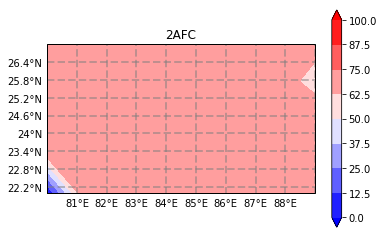

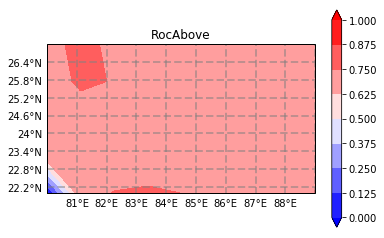

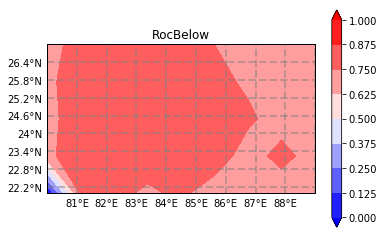

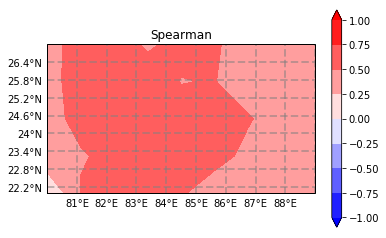

In [91]:
def pltscore(score,loni,lone,lati,late):
    """A simple plot function for ploting the statistical score
    
    PARAMETERS
    ----------
        score: the score
        loni: wester longitude
        lone: eastern longitude
        lati: southern latitude
        late: northern latitude
        title: title
    """
    H = 9
    W = 5
    Record = np.dtype(('float32', H*W))
    A = np.fromfile('../output/RFREQ_'+score+'_Jun-Aug_wk1.dat',dtype=Record, count=1).astype('float')
    var = A[0].reshape((H, W), order='F')
    var = np.transpose(var)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([loni,lone,lati,late])

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    #states_provinces = feature.NaturalEarthFeature(
    #    category='cultural',
    #    name='admin_1_states_provinces_lines',
    #    scale='50ml',
    #    facecolor='none')

    ax.add_feature(feature.LAND)
    ax.add_feature(feature.COASTLINE)
    #ax.add_feature(states_provinces, edgecolor='gray')
    ax.set_title(score)
    pl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    pl.xlabels_top = False
    pl.ylabels_right = False
    pl.xformatter = LONGITUDE_FORMATTER
    pl.yformatter = LATITUDE_FORMATTER
    
    #add if for levels, depending on each score
    if score == '2AFC':
        levels = np.linspace(0, 100, 9)
    if score == 'RocAbove':
        levels = np.linspace(0, 1, 9)
    if score == 'RocBelow':
        levels = np.linspace(0, 1, 9)
    if score == 'Spearman':
        levels = np.linspace(-1, 1, 9)
        
    CS=plt.contourf(np.linspace(wlo2, elo2, num=H), np.linspace(sla2, nla2, num=W), var, 
            levels = levels,
            cmap=plt.cm.bwr,
            extend='both') #,transform=proj)

    cbar = plt.colorbar(CS)
    plt.show()
    
pltscore('2AFC',wlo2,elo2,nla2,sla2)
pltscore('RocAbove',wlo2,elo2,nla2,sla2)
pltscore('RocBelow',wlo2,elo2,nla2,sla2)
pltscore('Spearman',wlo2,elo2,nla2,sla2)